**AUTHOR: VO TRAN HUONG GIANG**    
**STUDENT ID: 2211345002**

In [1]:
!pip install requests numpy pandas scikit-learn statsmodels arch matplotlib seaborn altair


[notice] A new release of pip available: 22.3 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Basic utilities
import requests
import json
import time
import numpy as np
import pandas as pd

# Machine Learning & Statistical Models
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_arch
from arch import arch_model

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt

# FETCHDATA LIBRARIES

In [3]:
class FetchData:
    def __init__(self, max_retries=5, delay=1):
        self.max_retries = max_retries
        self.delay = delay

    def fetch_yahoo_finance(self, symbol, start="2013-01-01", end="2025-02-12", interval="1d"):
        """
        Fetches all historical stock data from Yahoo Finance.
        Useful for global datasets (e.g., stocks in the UK).
        """
        period1 = int(pd.Timestamp(start).timestamp())
        period2 = int(pd.Timestamp(end).timestamp())

        url = f"https://query1.finance.yahoo.com/v8/finance/chart/{symbol}?period1={period1}&period2={period2}&interval={interval}"
        headers = {"User-Agent": "Mozilla/5.0"}

        session = requests.Session()
        session.headers.update(headers)

        for attempt in range(self.max_retries):
            response = session.get(url)
            if response.status_code == 200:
                break
            elif response.status_code == 429:
                time.sleep(5 * (attempt + 1))
            else:
                raise Exception(f"Error {response.status_code}: {response.reason}")

        data = response.json().get("chart", {}).get("result", [{}])[0]
        if "timestamp" not in data or "indicators" not in data:
            raise ValueError("Invalid response format")

        df = pd.DataFrame(data["indicators"]["quote"][0])
        df["time"] = pd.to_datetime(data["timestamp"], unit="s").normalize()
        df.set_index("time", inplace=True)

        return df.dropna().assign(index=symbol)

    def fetch_vietcap(self, symbol, timeframe="ONE_DAY", count_back=3850, to_timestamp=1739491200):
        """
        Fetches all historical stock data from Vietcap API.
        Useful for Vietnamese datasets (e.g., stocks in Vietnam).
        """
        url = "https://trading.vietcap.com.vn/api/chart/OHLCChart/gap-chart"
        
        payload = json.dumps({
            "timeFrame": timeframe,
            "symbols": [symbol],
            "countBack": count_back,
            "to": to_timestamp
        })
        
        headers = {
            "User-Agent": "Mozilla/5.0",
            "Accept": "application/json",
            "Content-Type": "application/json"
        }
        
        response = requests.post(url, headers=headers, data=payload)
        time.sleep(self.delay)
        
        if response.status_code != 200:
            raise Exception(f"Error {response.status_code}: {response.reason}")
        
        df = pd.DataFrame(response.json()).explode(['o', 'h', 'l', 'c', 'v', 't']).rename(columns={
            't': 'time', 'o': 'open', 'h': 'high', 'l': 'low', 'c': 'close', 'v': 'volume'
        })
        
        df['time'] = pd.to_datetime(df['time'], unit='s')
        df[['open', 'high', 'low', 'close', 'volume']] = df[['open', 'high', 'low', 'close', 'volume']].apply(pd.to_numeric, errors='coerce')
        
        return df.set_index('time')[['open', 'high', 'low', 'close', 'volume']].assign(index=symbol)


# I. INTRODUCTION

**_Rationale_**  
Despite some lingering negative signals, the Vietnamese stock market has exhibited strong positive momentum in 2024, reinforcing my belief that VNINDEX has the potential to reach 1400 in the near future. This optimism is not only supported by technical indicators but also by fundamental economic factors, corporate performance, and investor sentiment. From a technical perspective, VNINDEX remains in an upward price channel, trading above its long-term moving averages, with stochastic indicators showing bullish momentum. Fundamentally, Vietnam’s trade balance has reached record highs, economic growth continues to show resilience, and the number of retail investors entering the market is steadily increasing. However, risks remain—foreign investors have been net sellers despite the country’s strong export performance, partly due to currency depreciation and capital outflows from emerging markets. Additionally, liquidity has not yet fully shifted into the stock market, with significant capital flowing into alternative assets like gold and cryptocurrencies.

**_Research scope and application_**  
In this study, I analyze both the bullish (technical and fundamental) and bearish (monetary and cash flow) factors to assess the probability of a sustained uptrend in 2025. To strengthen the argument for an upward trajectory, I employ machine learning techniques, specifically Random Forest Regression, to forecast VNINDEX based purely on historical data movements. Additionally, for robustness and comparability, I incorporate ARIMA combined with GARCH to perform a statistical regression analysis, benchmarking its results against the machine learning model. This study aims to serve as a valuable reference for investors seeking to understand market trends, manage risk, and optimize their investment strategies.

# II. OVERVIEW

**Positive market overview:**  
* The VNINDEX is poised for potential growth, aiming towards the 1400 points mark by 2025.  
* Recent trading sessions have shown positive trends, supported by increased trading volumes.

## Technical signals indicating growth

In [31]:
from fetchdata import *

# Create an instance of the FetchData class
fetcher = FetchData()
# Fetch S&P 500 data from Yahoo Finance
sp500 = fetcher.fetch_yahoo_finance("^GSPC")
# Fetch VNINDEX data from Vietcap
vnindex = fetcher.fetch_vietcap('VNINDEX')

d:\Github\Repo1_HuongGiang\AI Application for Finance\Midterm Assignment\fetchdata.py:74: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['time'] = pd.to_datetime(df['time'], unit='s')


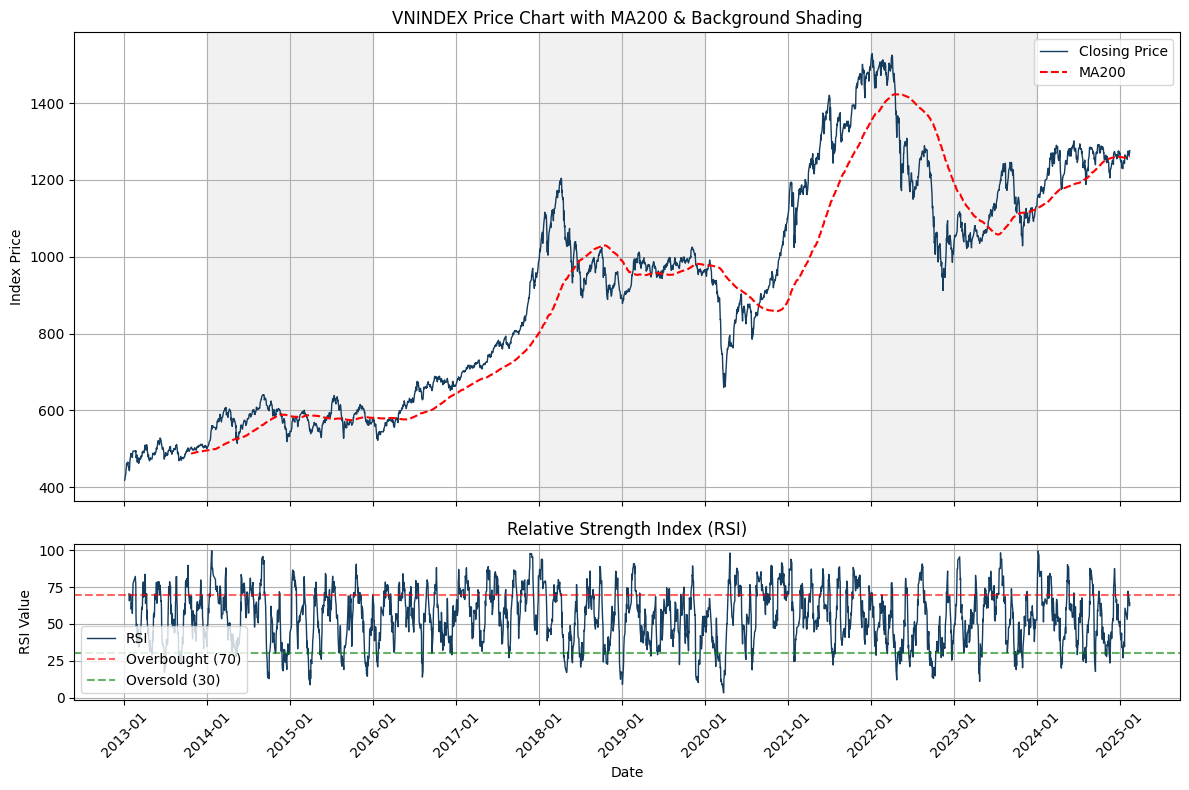

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Ensure DataFrame is loaded
vnindex['time'] = pd.to_datetime(vnindex.index)

# Calculate Moving Averages
vnindex['MA20'] = vnindex['close'].rolling(window=20).mean()
vnindex['MA50'] = vnindex['close'].rolling(window=50).mean()
vnindex['MA200'] = vnindex['close'].rolling(window=200).mean()

# Compute RSI
def compute_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

vnindex['RSI'] = compute_rsi(vnindex['close'])

# Define background shading periods
background_periods = [
    ('2014-01-01', '2015-12-31'),
    ('2018-01-01', '2019-12-31'),
    ('2022-01-01', '2023-12-31')
]

# Create figure
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# Add background shading
for start, end in background_periods:
    ax1.axvspan(pd.to_datetime(start), pd.to_datetime(end), color='lightgrey', alpha=0.3)

# Plot Price & Moving Averages
ax1.plot(vnindex['time'], vnindex['close'], label="Closing Price", color='#143D60', linewidth=1)
# ax1.plot(vnindex['time'], vnindex['MA20'], label="MA20", color='gold', linestyle='dashed')
# ax1.plot(vnindex['time'], vnindex['MA50'], label="MA50", color='green', linestyle='dashed')
ax1.plot(vnindex['time'], vnindex['MA200'], label="MA200", color='red', linestyle='dashed')

ax1.set_title("VNINDEX Price Chart with MA200 & Background Shading")
ax1.set_ylabel("Index Price")
ax1.legend()
ax1.grid()

# RSI Chart
ax2.plot(vnindex['time'], vnindex['RSI'], label="RSI", color='#143D60', linewidth=1)
ax2.axhline(70, linestyle='dashed', color='red', alpha=0.6, label="Overbought (70)")
ax2.axhline(30, linestyle='dashed', color='green', alpha=0.6, label="Oversold (30)")

ax2.set_title("Relative Strength Index (RSI)")
ax2.set_ylabel("RSI Value")
ax2.set_xlabel("Date")
ax2.legend()
ax2.grid()

# Formatting date axis
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax1.xaxis.set_major_locator(mdates.YearLocator())

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# III. DATA ANALYSIS

In [33]:
from fetchdata import *

# Create an instance of the FetchData class
fetcher = FetchData()
# Fetch S&P 500 data from Yahoo Finance
sp500 = fetcher.fetch_yahoo_finance("^GSPC")
# Fetch VNINDEX data from Vietcap
vnindex = fetcher.fetch_vietcap('VNINDEX')

d:\Github\Repo1_HuongGiang\AI Application for Finance\Midterm Assignment\fetchdata.py:74: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['time'] = pd.to_datetime(df['time'], unit='s')


In [6]:
vnindex

,open,high,low,close,volume,index
time,,,,,,
2013-01-02,415.50,419.05,414.41,418.35,64288223,VNINDEX
2013-01-03,420.68,420.68,413.68,419.27,99824757,VNINDEX
2013-01-04,418.75,426.48,417.50,426.06,64852320,VNINDEX
2013-01-07,428.84,434.64,426.86,434.19,78123432,VNINDEX
2013-01-08,437.25,447.16,437.15,447.16,119101143,VNINDEX
...,...,...,...,...,...,...
2025-02-10,1275.20,1275.20,1263.26,1263.26,794054460,VNINDEX
2025-02-11,1263.26,1268.45,1263.11,1268.45,622260600,VNINDEX
2025-02-12,1268.45,1272.86,1266.59,1266.91,504507839,VNINDEX


In [7]:
sp500

,low,high,volume,open,close,index
time,,,,,,
2013-01-02,1426.189941,1462.430054,4202600000,1426.189941,1462.420044,^GSPC
2013-01-03,1455.530029,1465.469971,3829730000,1462.420044,1459.369995,^GSPC
2013-01-04,1458.989990,1467.939941,3424290000,1459.369995,1466.469971,^GSPC
2013-01-07,1456.619995,1466.469971,3304970000,1466.469971,1461.890015,^GSPC
2013-01-08,1451.640015,1461.890015,3601600000,1461.890015,1457.150024,^GSPC
...,...,...,...,...,...,...
2025-02-05,6007.060059,6062.859863,4756250000,6020.450195,6061.479980,^GSPC
2025-02-06,6046.830078,6084.029785,4847120000,6072.220215,6083.569824,^GSPC
2025-02-07,6019.959961,6101.279785,4766900000,6083.129883,6025.990234,^GSPC


**_1. Graphing data and recognizing the relationship between S&P500 and VNINDEX._**

In [8]:
# FIGURE 5
sp500 = sp500.reset_index()
vnindex = vnindex.reset_index()

def create_chart(df, title):
    base = alt.Chart(df).encode(x='time:T')

    # Define background shading for multiple periods
    background_data = pd.DataFrame({
        'start': ['2014-01-01', '2018-01-01', '2022-01-01'],
        'end': ['2015-12-31', '2019-12-31', '2023-12-31'],
        'color': ['lightgrey', 'lightgrey', 'lightgrey']
    })

    background = alt.Chart(background_data).mark_rect(opacity=0.3).encode(
        x='start:T',
        x2='end:T',
        color=alt.Color('color:N', scale=None)  # Keep color mapping fixed
    )

    # Volume bar chart (Secondary y-axis)
    volume_chart = base.mark_bar(color='#143D60', size=3).encode(
        y=alt.Y('volume:Q',
                axis=alt.Axis(title='Volume', orient='right', titleColor='black', tickCount=10),
                scale=alt.Scale(domain=[0, df['volume'].max() * 3.5], nice=False))
    )

    # Closing price line chart (Primary y-axis)
    close_chart = base.mark_line(color='#578FCA', strokeWidth=2).encode(
        y=alt.Y('close:Q', axis=alt.Axis(title='Closing Price (points)', titleColor='black'))
    )

    # Combine all layers
    combined_chart = (
        alt.layer(background, volume_chart, close_chart)
        .resolve_scale(y='independent')
        .properties(title=title, width=600, height=300)
    )

    return combined_chart

# Create individual charts
sp500_chart = create_chart(sp500, "S&P 500 Price & Volume")
vnindex_chart = create_chart(vnindex, "VNINDEX Price & Volume")

# Stack the charts vertically
final_chart = alt.vconcat(sp500_chart, vnindex_chart).configure_view(
    strokeWidth=0  # Remove default border
)

# Display the final chart
final_chart


alt.VConcatChart(...)

**_2. Data processing_**

In [9]:
# Calculate returns
vnindex['close_pct'] = vnindex['close'].pct_change()*100
sp500['close_pct'] = sp500['close'].pct_change()*100

# Drop NaN rows
vnindex = vnindex.dropna(subset=['close_pct'])
sp500 = sp500.dropna(subset=['close_pct'])

In [10]:
# Set time as index
sp500 = sp500.set_index('time')
vnindex = vnindex.set_index('time')

In [11]:
# Merge the DataFrames based on the 'time' column
database = pd.merge(sp500, vnindex, on='time', suffixes=('_sp500', '_vnindex'))

# Select only the desired columns
database = database[['close_pct_sp500', 'close_pct_vnindex']]
database_vnindex = database[['close_pct_vnindex']]
database_sp500 = database[['close_pct_sp500']]

**_3. Summary statistics_**  
**a. Descriptive statistics**

In [12]:
# Compute summary statistics table
pd.options.display.float_format = '{:,.4f}'.format 
summary_stats = database.describe()  
summary_stats

,close_pct_sp500,close_pct_vnindex
count,"2,924.0000","2,924.0000"
mean,0.0538,0.0449
std,1.0684,1.1256
min,-11.9841,-6.6744
25%,-0.3630,-0.4328
50%,0.0716,0.1195
75%,0.5610,0.6365
max,9.3828,4.9801


**b. Histogram and times series plot**

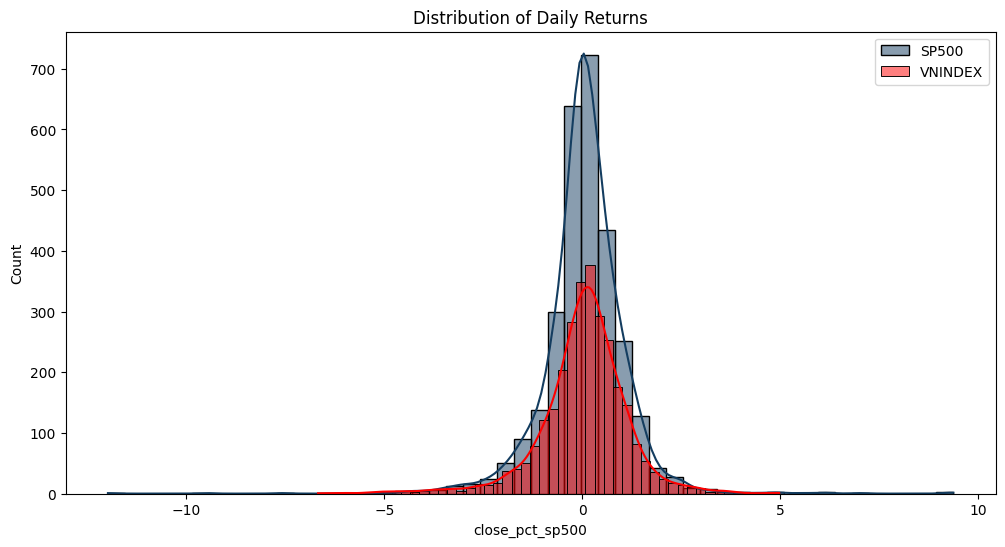

In [13]:
# Histogram & Density Plot
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12,6))
sns.histplot(database['close_pct_sp500'], bins=50, kde=True, color='#143D60', label="SP500")
sns.histplot(database['close_pct_vnindex'], bins=50, kde=True, color='red', label="VNINDEX")
plt.legend()
plt.title("Distribution of Daily Returns")
plt.show()

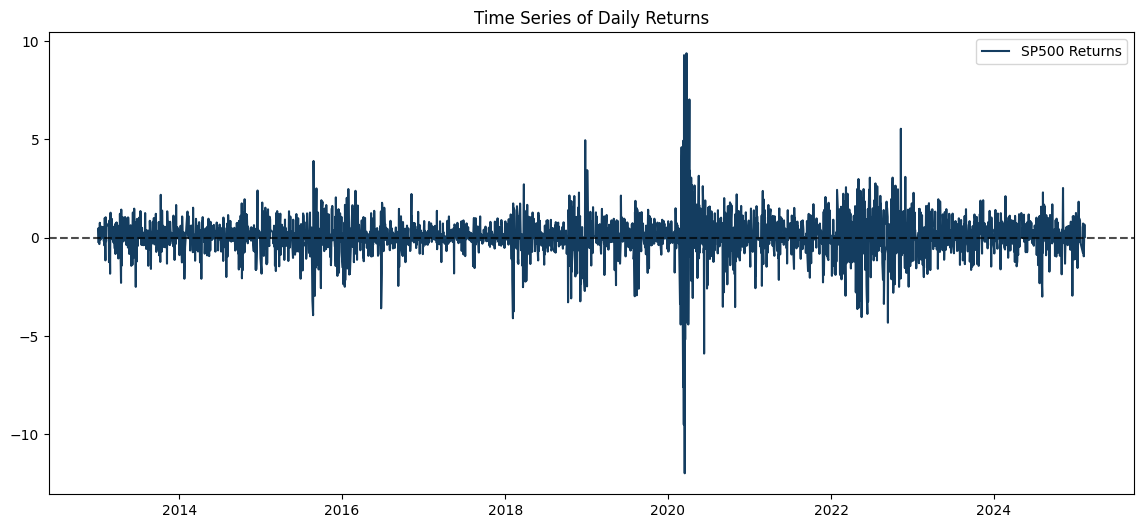

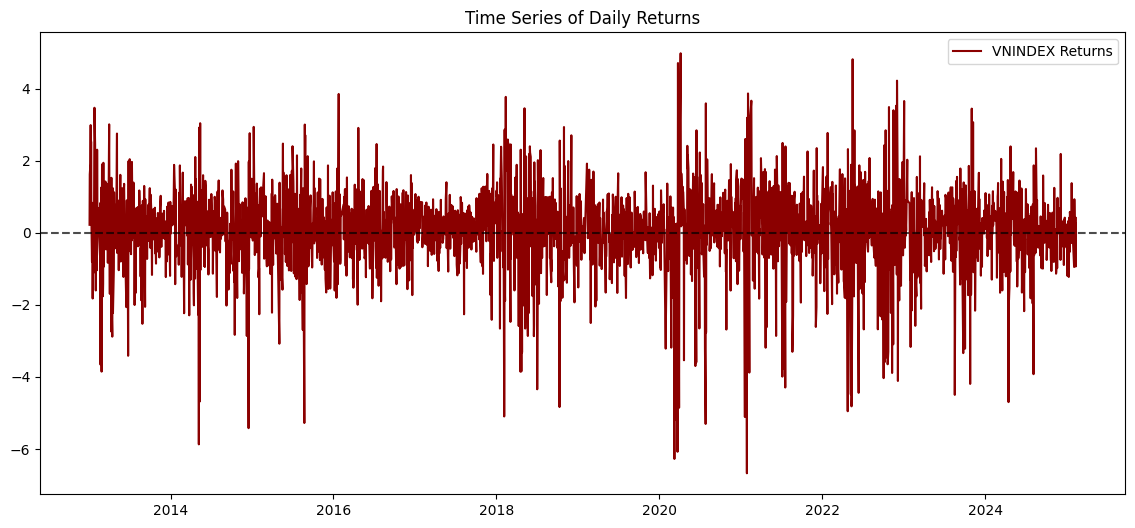

In [14]:
# Time Series Plot
plt.figure(figsize=(14,6))
plt.plot(database.index, database['close_pct_sp500'], label='SP500 Returns', color='#143D60')
plt.axhline(y=0, color='black', linestyle='--', alpha=0.7)
plt.legend()
plt.title("Time Series of Daily Returns")
plt.show()

plt.figure(figsize=(14,6))
plt.plot(database.index, database['close_pct_vnindex'], label='VNINDEX Returns', color='darkred')
plt.axhline(y=0, color='black', linestyle='--', alpha=0.7)
plt.legend()
plt.title("Time Series of Daily Returns")
plt.show()


**_c. Correlation matrix_**

In [15]:
# Calculate correlation
correlation = database[['close_pct_sp500','close_pct_vnindex']].corr()   
correlation

,close_pct_sp500,close_pct_vnindex
close_pct_sp500,1.0000,0.0974
close_pct_vnindex,0.0974,1.0000


# IV. MODEL ASSESSMENTS

## **_Set up libraries_**

**_1. Prepares time-series data for model training and testing_**  

`data_preprocessing` prepares time-series data for model training and testing. It takes the time-series data, the number of lags to consider (`num_lags`), and the train-test split ratio (`train_test_split`) as input.  The function creates lagged features (x) and corresponding target values (y). Specifically, for each point in the time series (excluding the last     `num_lags` points), it creates a feature vector by taking the preceding `num_lags` values. The corresponding target value is the value at the next time step. The data is then split into training and testing sets based on the provided `train_test_split` ratio. The function returns the training features, training targets, testing features, and testing targets.

In [21]:
def data_preprocessing(data, num_lags, train_test_split):
    """Prepares time-series data for model training and testing."""
    x, y = [], []
    for i in range(len(data) - num_lags):
        x.append(data[i:i + num_lags])
        y.append(data[i + num_lags])
    
    x, y = np.array(x), np.array(y)
    split_index = int(train_test_split * len(x))
    return x[:split_index], y[:split_index], x[split_index:], y[split_index:]

**_2. RandomForest Regressor_**  

`get_random_forest_regressor` function written by myself simplifies the initialization of a Random Forest model for regression tasks. Built upon `BaggingRegressor`, it allows users to easily set key parameters such as the number of trees (`n_estimators`), the maximum depth of each tree (`max_depth`), and the `random_state` for reproducibility. Using `BaggingRegressor` with `DecisionTreeRegressor` as the base estimator is a common approach to building Random Forest models, leveraging the benefits of bagging to reduce overfitting and improve accuracy.

In [22]:
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import BaggingRegressor, BaggingClassifier

def get_random_forest_regressor(n_estimators=100, max_depth=None, random_state=None):
    """
    Bagging-based Random Forest Regressor.
    Defaults:
    - n_estimators=100
    - max_depth=None
    - random_state=None
    """
    return BaggingRegressor(
        estimator=DecisionTreeRegressor(max_depth=max_depth, random_state=random_state), 
        n_estimators=n_estimators,
        bootstrap=True,
        n_jobs=-1,
        random_state=random_state
    )

**_3. Plots training, test, and predicted values for visualization_**  

`plot_train_test_values` visualizes the training, test, and predicted values of a time series. It takes the window size, training window size, training data, test data, and predicted values as input. The function generates a plot displaying the training data, test data, and the model's predictions, clearly separated by a vertical line indicating the split between training and testing periods.  This allows for a direct visual comparison of the model's performance on the test set.

In [23]:
def plot_train_test_values(window, train_window, y_train, y_test, y_predicted):
    """Plots training, test, and predicted values for visualization."""
    plt.figure(figsize=(15, 6))
    prediction_window, first, second = window, train_window, window - train_window
    y_predicted, y_test = np.reshape(y_predicted, (-1, 1)), np.reshape(y_test, (-1, 1))
    
    plotting_time_series = np.zeros((prediction_window, 3))
    plotting_time_series[0:first, 0], plotting_time_series[first:, 1], plotting_time_series[first:, 2] = (
        y_train[-first:], y_test[:second, 0], y_predicted[:second, 0]
    )
    plotting_time_series[:first, 1:] = np.nan
    plotting_time_series[first:, 0] = np.nan
    
    plt.plot(plotting_time_series[:, 0], label='Training data', color='#143D60', linewidth=2.5)
    plt.plot(plotting_time_series[:, 1], label='Test data', color='#143D60', linestyle='dashed', linewidth=2)
    plt.plot(plotting_time_series[:, 2], label='Predicted data', color='red', linewidth=1)
    plt.axvline(x=first, color='#143D60', linestyle='--', linewidth=1)
    plt.grid()
    plt.legend()
    plt.show()

**_4. ARIMA + GARCH Model_**

`fit_arima_garch` fits ARIMA and, if necessary, GARCH models to time series data. It first fits an ARIMA model and then performs an ARCH test on the residuals to detect heteroskedasticity. If significant heteroskedasticity is present, a GARCH model is fitted to the residuals. The function returns the fitted ARIMA model and the fitted GARCH model (or None if no GARCH model was fitted).

In [24]:
def fit_arima_garch(data, arima_order=(2, 1, 1), garch_order=(1, 1), dist='normal'):
    """
    Fits ARIMA and GARCH models to the provided data.
    
    Parameters:
    data (array-like): Time series data
    arima_order (tuple): Order of the ARIMA model (p, d, q)
    garch_order (tuple): Order of the GARCH model (p, q)
    dist (str): Distribution for the GARCH model. Default is 'normal'.
    
    Returns:
    result_arima: Fitted ARIMA model
    result_garch: Fitted GARCH model (if heteroskedasticity is detected)
    """
    # Fit ARIMA Model
    model_arima = ARIMA(data, order=arima_order)
    result_arima = model_arima.fit()

    # Extract residuals from ARIMA model
    residuals = result_arima.resid

    # Perform ARCH test to check for heteroskedasticity
    arch_test = het_arch(residuals)
    p_value = arch_test[1]  
    print(f"P-value from ARCH Test: {p_value}")

    result_garch = None
    # If p-value < 0.05, it indicates presence of heteroskedasticity → use GARCH
    if p_value < 0.05:
        print("Significant heteroskedasticity detected. Applying GARCH model...")

        # Fit GARCH(1,1) model to ARIMA residuals
        garch_model = arch_model(residuals, vol='Garch', p=garch_order[0], q=garch_order[1], dist=dist)
        result_garch = garch_model.fit(disp="off")  # Suppress output for cleaner results
        
        # Print GARCH results summary
        print(result_garch.summary())

        # Show p-values after GARCH
        garch_residuals = result_garch.resid  # Extract residuals from GARCH
        arch_test_after_garch = het_arch(garch_residuals)
        print(f"P-value after GARCH: {arch_test_after_garch[1]}")
    else:
        print("No significant heteroskedasticity detected. GARCH model may not be needed.")
    
    return result_arima, result_garch

**_5. Evaluating ratios_**

In [25]:
# A. R-Squared Metric
def r_squared(predicted_returns, real_returns):
    return 1 - np.sum((real_returns - predicted_returns) ** 2) / np.sum((real_returns - np.mean(real_returns)) ** 2)

# B. Predictive Accuracy Metrics
class predictiveaccuracy:
    @staticmethod
    def mean_squared_error(predicted_returns, real_returns):
        return np.mean((predicted_returns - real_returns) ** 2)
    
    @staticmethod
    def mean_absolute_error(predicted_returns, real_returns):
        return np.mean(np.abs(predicted_returns - real_returns))
    
    @staticmethod
    def mean_absolute_percentage_error(predicted_returns, real_returns):
        return np.mean(np.abs((predicted_returns - real_returns) / real_returns)) * 100
    
# C. Directional Accuracy Metrics
def accuracy(predicted_returns, real_returns):
    predicted_returns = np.reshape(predicted_returns, (-1, 1))
    real_returns = np.reshape(real_returns, (-1, 1))
    hits = np.sum(np.sign(predicted_returns) == np.sign(real_returns))
    total_samples = len(predicted_returns)
    return (hits / total_samples) * 100

# D. Directional Bias Metrics
def model_bias(predicted_returns):
    bullish_forecasts = np.sum(predicted_returns > 0)
    bearish_forecasts = np.sum(predicted_returns < 0)
    return bullish_forecasts / bearish_forecasts if bearish_forecasts != 0 else np.inf

## **_1. Machine Learning Model: RandomForest Regression_**

In [34]:
# close_pct_vnindex
values_vnindex = database['close_pct_vnindex'].values
values_vnindex

array([ 0.21991156,  1.61948148,  1.90818195, ...,  0.29257244,
       -0.93632371,  0.41084179])

### **_RandomForest Regression_**

* The process starts with setting hyperparameters, where `num_lags = 500` determines how many past observations are used to predict future values, and `train_test_split = 0.80` specifies that 80% of the data is used for training while 20% is reserved for testing. 
* Next, the `data_preprocessing` function transforms the time-series data into input-output pairs, creating `x_train`, `y_train` for training and `x_test`, `y_test` for testing. 
* A Random Forest Regressor model is then initialized with 100 trees and a maximum depth of 20. The model is trained using `x_train` and `y_train`, learning the relationship between input features and target values. 
* Finally, predictions are made both in-sample (on training data) and out-of-sample (on test data), reshaping them for further analysis and evaluation.

In [35]:
# Setting the hyperparameters
num_lags = 500
train_test_split = 0.80
# Creating the training and test sets
x_train, y_train, x_test, y_test = data_preprocessing(values_vnindex, num_lags, train_test_split)
# Fitting the model
model = get_random_forest_regressor(n_estimators=100, max_depth=20, random_state=123)
model.fit(x_train, y_train)

# Predicting in-sample
y_predicted_train = np.reshape(model.predict(x_train), (-1, 1))
# Predicting out-of-sample
y_predicted = np.reshape(model.predict(x_test), (-1, 1))

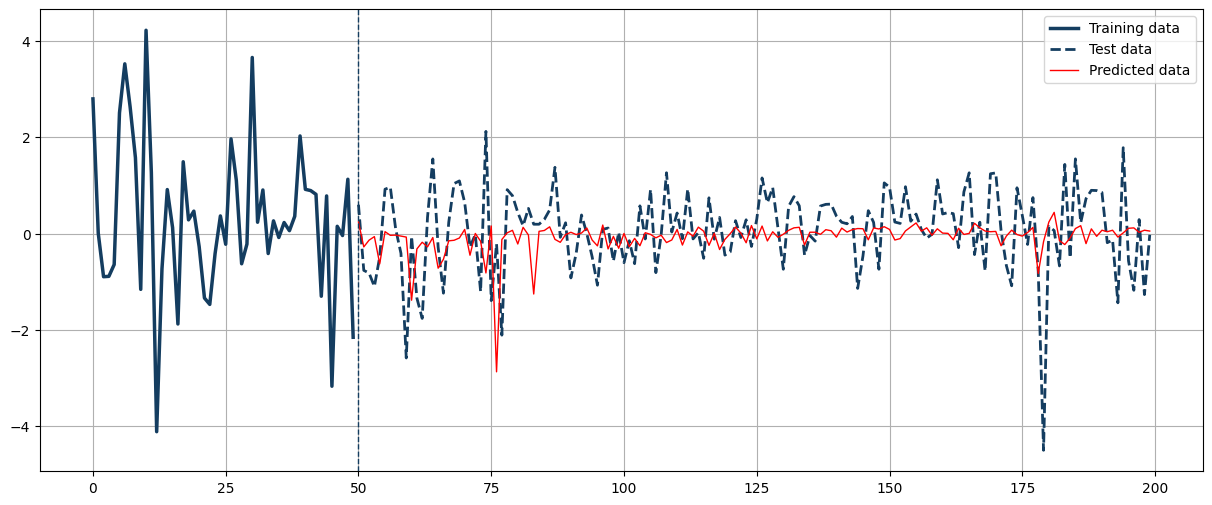

In [36]:
# plotting
plot_train_test_values(window=200, train_window=50,
                       y_train=y_train, y_test=y_test, y_predicted=y_predicted)

In [37]:
# Performance evaluation
print('---')
print('Accuracy Train = ', round(accuracy(y_predicted_train, y_train), 2), '%')
print('Accuracy Test = ', round(accuracy(y_predicted, y_test), 2), '%')
print('RMSE Train = ', round(np.sqrt(mean_squared_error(y_predicted_train, y_train)), 10))
print('RMSE Test = ', round(np.sqrt(mean_squared_error(y_predicted, y_test)), 10))
print('Correlation In-Sample Predicted/Train = ', round(np.corrcoef(np.reshape(y_predicted_train, (-1)), y_train)[0][1], 3))
print('Correlation Out-of-Sample Predicted/Test = ', round(np.corrcoef(np.reshape(y_predicted, (-1)), np.reshape(y_test, (-1)))[0][1], 3))
print('Model Bias = ', round(model_bias(y_predicted), 2))
print('---')

---
Accuracy Train =  80.04 %
Accuracy Test =  50.72 %
RMSE Train =  0.7390302378
RMSE Test =  0.9706804717
Correlation In-Sample Predicted/Train =  0.904
Correlation Out-of-Sample Predicted/Test =  -0.034
Model Bias =  1.22
---


In [38]:
# Desciptive statistics
# Assuming y_predicted is a numpy array
y_predicted_series = pd.Series(y_predicted.flatten())
print('-----Prediction')
print(y_predicted_series.describe())
print('-----Actual')
# Assuming y_predicted is a numpy array
y_test_series = pd.Series(y_test.flatten())
print(y_test_series.describe())

-----Prediction
count   485.0000
mean     -0.0300
std       0.2494
min      -2.8698
25%      -0.0922
50%       0.0134
75%       0.0980
max       0.4400
dtype: float64
-----Actual
count   485.0000
mean      0.0313
std       0.9287
min      -4.6992
25%      -0.4104
50%       0.0964
75%       0.5560
max       3.4444
dtype: float64


## **_2. Econometrics Model: ARIMA + GARCH_** 

### **_Application: ARIMA Model + GARCH Model_**

#### **_1. Stationary for Dataset_** 

 VNINDEX has ADF test statistics that are highly negative and p-values of 0.000, indicating strong evidence to reject the null hypothesis of a unit root. This means both the index is stationary at its current value, meaning that using **first-order differencing** to achieve stationarity for time series modeling like ARIMA is appropriate. From that, we would have the **_value of Intergrated - d is 1_**.
* **_ARIMA(p,1,q)_**

In [50]:
values_vnindex = database['close_pct_vnindex'].values

In [51]:
# ADF
def adf_test(series):
    result = adfuller(series)
    adf_statistic = result[0]
    p_value = result[1]
    print('ADF Statistic: %f' % adf_statistic)
    print('p-value: %f' % p_value)
    return result

print('\nADF Test for VNINDEX:')
p_value_vnindex = adf_test(values_vnindex)[1]


ADF Test for VNINDEX:
ADF Statistic: -17.942358
p-value: 0.000000


#### **_2. Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF)_**

The ACF plot shows the correlation between a time series and its own lagged values, with the horizontal axis representing the lag and the vertical axis representing the correlation coefficient. From the graph, we can see that with **_lag value at 1 and 2, the bars exceed the confidence interval_**, indicating a significant correlation between the time series and its lagged variables. From that, **value of AR(p) would be 1 or 2**. Same can be observed in PACF with **MA(q) = 1 or 2**. Therefore, four options would be tested:
* **ARIMA(1,1,1)**
* **ARIMA(2,1,1)**
* **ARIMA(1,1,2)**
* **ARIMA(2,1,2)**

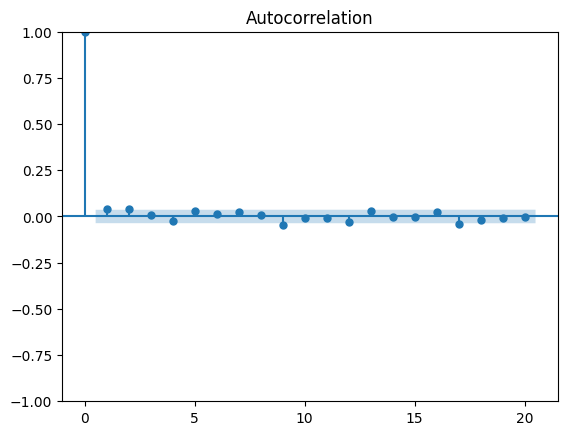

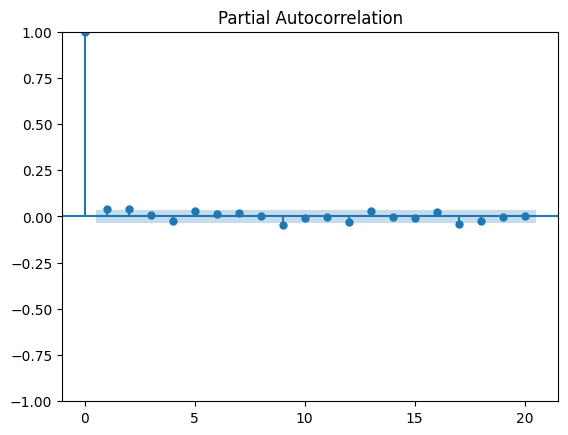

In [52]:
# plot ACF and PACF
plot_acf(values_vnindex, lags=20)
plt.show()
plot_pacf(values_vnindex, lags=20)
plt.show()

#### **_3. Testing for ARIMA Model_**

In [53]:
# ARIMA(2,1,1) model for VNINDEX
model = ARIMA(values_vnindex, order=(2, 1, 1))
model_fit = model.fit()
print(model_fit.summary())

# ARIMA(1,1,1) model for VNINDEX
# model = ARIMA(values_vnindex, order=(1, 1, 1))
# model_fit = model.fit()
# print(model_fit.summary())

# ARIMA(1,1,2) model for VNINDEX
# model = ARIMA(values_vnindex, order=(1, 1, 2))
# model_fit = model.fit()
# print(model_fit.summary())

# ARIMA(2,1,2) model for VNINDEX
# model = ARIMA(values_vnindex, order=(2, 1, 2))
# model_fit = model.fit()
# print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2924
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -4492.492
Date:                Wed, 26 Feb 2025   AIC                           8992.984
Time:                        00:43:20   BIC                           9016.905
Sample:                             0   HQIC                          9001.600
                               - 2924                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0381      0.013      3.014      0.003       0.013       0.063
ar.L2          0.0420      0.012      3.498      0.000       0.018       0.066
ma.L1         -1.0000      0.044    -22.770      0.0

#### **_4. GARCH(1,1) - to solve Heteroskedasticity_**

In [54]:
result_arima, result_garch = fit_arima_garch(values_vnindex, arima_order=(2, 1, 1), garch_order=(1, 1), dist='normal')

 # Show p-values after GARCH
garch_residuals = result_garch.resid  # Extract residuals from GARCH
arch_test_after_garch = het_arch(garch_residuals)

print(result_garch.summary())
print(f"P-value after GARCH: {arch_test_after_garch[1]}")

P-value from ARCH Test: 5.155940962705091e-66
Significant heteroskedasticity detected. Applying GARCH model...
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4159.01
Distribution:                  Normal   AIC:                           8326.03
Method:            Maximum Likelihood   BIC:                           8349.95
                                        No. Observations:                 2924
Date:                Wed, Feb 26 2025   Df Residuals:                     2923
Time:                        00:43:21   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
--------------------

#### **_5. GARCH with Student's t-distribution - to solve Heteroskedasticity_**

In [55]:
result_arima, result_garch = fit_arima_garch(values_vnindex, arima_order=(2, 1, 1), garch_order=(1, 1), dist='t')

 # Show p-values after GARCH
garch_residuals = result_garch.resid  # Extract residuals from GARCH
arch_test_after_garch = het_arch(garch_residuals)

print(result_garch.summary())
print(f"P-value after GARCH: {arch_test_after_garch[1]}")

P-value from ARCH Test: 5.155940962705091e-66
Significant heteroskedasticity detected. Applying GARCH model...
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -4026.18
Distribution:      Standardized Student's t   AIC:                           8062.36
Method:                  Maximum Likelihood   BIC:                           8092.26
                                              No. Observations:                 2924
Date:                      Wed, Feb 26 2025   Df Residuals:                     2923
Time:                              00:43:22   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t    

#### **_6. Predictions: ARIMA + GARCH with Student's t-distribution_**

`fit_arima_garch` function combines ARIMA and GARCH models for forecasting (mentioned in "_Set up libraries_"). As described in the "_Introduction to ARIMA_", this model relies on two key components: AutoRegressive (AR), which uses past values of the series, and Moving Average (MA), which captures past residuals or white noise. The forecast function from the `statsmodels` library applies Maximum Likelihood Estimation (MLE) to fit the ARIMA model by maximizing the likelihood of observing the actual data.

However, due to the presence of heteroskedasticity (changing variance over time), we incorporate GARCH (Generalized Autoregressive Conditional Heteroskedasticity). The GARCH model focuses on analyzing and modeling residuals, also using MLE to improve forecasting accuracy by capturing volatility dynamics.

**_Unlike machine learning models, such as Random Forest Regression, ARIMA+GARCH does not require splitting the dataset into training and testing sets. Instead, it makes an `adjusted_forecast` (`y_predicted`) based on historical data (`y_train`) without needing `y_test`. To ensure consistency when comparing results with Random Forest Regression, we use `y_train` as an input for this model instead of whole dataset (values_vnindex)._**

In [56]:
%%capture
result_arima, result_garch = fit_arima_garch(y_train, arima_order=(2, 1, 1), garch_order=(1, 1), dist='t') # not show output

In [57]:
forecast_horizon = 485  # Define number of future steps to predict, choose 485 to match the test set

# forecast arima
arima_forecast = result_arima.forecast(steps=forecast_horizon)

# forecast garch
garch_forecast_df = result_garch.forecast(horizon=forecast_horizon).variance
# Extract the last row (as a Series) and convert variance to standard deviation
garch_forecast = np.sqrt(garch_forecast_df.iloc[-1, :].values)  

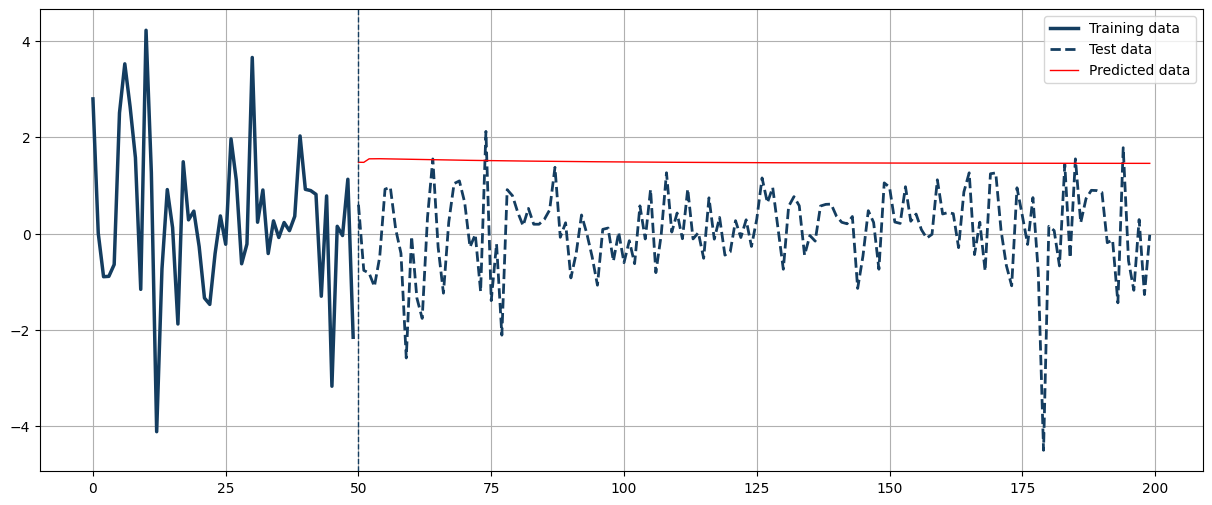

In [58]:
# Calculate adjusted_forecast
adjusted_forecast = arima_forecast + garch_forecast
#reshape adjusted_forecast to 2D array
adjusted_forecast = np.reshape(adjusted_forecast, (-1, 1))
# plotting
plot_train_test_values(window=200, train_window=50,
                       y_train=y_train, y_test=y_test, y_predicted=adjusted_forecast)

In [59]:
# Performance evaluation
print('---')
print('Accuracy Test = ', round(accuracy(adjusted_forecast, y_test), 2), '%')
print('RMSE Test = ', round(np.sqrt(mean_squared_error(adjusted_forecast, y_test)), 10))
print('Correlation Out-of-Sample Predicted/Test = ', round(np.corrcoef(np.reshape(adjusted_forecast, (-1)), np.reshape(y_test, (-1)))[0][1], 3))
print('Model Bias = ', round(model_bias(adjusted_forecast), 2))
print('---')

---
Accuracy Test =  55.67 %
RMSE Test =  1.7069870448
Correlation Out-of-Sample Predicted/Test =  -0.037
Model Bias =  inf
---


In [60]:
# Desciptive statistics
# Assuming y_predicted is a numpy array
y_predicted_series = pd.Series(adjusted_forecast.flatten())
print('-----Prediction')
print(y_predicted_series.describe())
print('-----Actual')
# Assuming y_predicted is a numpy array
y_test_series = pd.Series(y_test.flatten())
print(y_test_series.describe())

-----Prediction
count   485.0000
mean      1.4635
std       0.0196
min       1.4548
25%       1.4548
50%       1.4550
75%       1.4600
max       1.5535
dtype: float64
-----Actual
count   485.0000
mean      0.0313
std       0.9287
min      -4.6992
25%      -0.4104
50%       0.0964
75%       0.5560
max       3.4444
dtype: float64


## **_3. Comparison: Econometrics Method and Machine Learning Method_**

Set of metrics to compare ARIMA+GARCH and Random Forest models, especially for financial time series forecasting:  
_(Detail about formula mentioned in "Set up libraries")_

**_A. R-Squared (Coefficient of Determination)_**  
 R-squared measures the proportion of the variance in the dependent variable (real returns) that is predictable from the independent variables (past returns, etc.). A higher R-squared suggests a better fit. While not perfect for time series (due to potential spurious regressions), it still provides a general sense of how well the model captures the overall variability.
$$R^2 = 1 - \frac{\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}{\sum_{i=1}^{n}(y_i - \bar{y})^2}$$


**_B. Predictive Accuracy Metrics (MSE, MAE, MAPE)_**  
These metrics evaluate the magnitude of the errors between the predicted and actual returns.
* **MSE (Mean Squared Error)**: 
  * Penalizes larger errors more heavily due to the squaring. Sensitive to outliers. 
  * $MSE = \frac{1}{N} \sum_{i=1}^{N} (r_i^p - r_i^r)^2$
   
* **MAE (Mean Absolute Error)**: 
  * Treats all errors equally. Less sensitive to outliers.   
  * $MAE = \frac{1}{N} \sum_{i=1}^{N} |r_i^p - r_i^r|$

* **MAPE (Mean Absolute Percentage Error)**: 
  * Expresses errors as a percentage of the actual returns. Useful for comparing models across different scales, but can be problematic if actual returns are close to zero.
  * $MAPE = \frac{1}{N} \sum_{i=1}^{N} \left| \frac{r_i^p - r_i^r}{r_i^r} \right| \times 100\%$

**_C. Directional Accuracy_**  
In financial trading, often the direction of the price movement (up or down) is more important than the exact magnitude. Directional accuracy measures how often the model correctly predicts the direction of the return.
$$Accuracy = \frac{\sum_{i=1}^{N} I(\text{sign}(r_i^p) = \text{sign}(r_i^r))}{N} \times 100\%$$

**_D. Directional Bias_**  
This metric reveals if the model has a tendency to be overly bullish or bearish. A bias can lead to unbalanced trading signals and potentially significant losses. It helps identify if the model is systematically over- or under-predicting positive or negative returns.
$$Bias = \frac{\sum_{i=1}^{N} I(r_i^p > 0)}{\sum_{i=1}^{N} I(r_i^p < 0)}$$


In [61]:
# ARIMA + GARCH Model
r_squared_arima_garch = r_squared(adjusted_forecast, y_test)
mean_squared_error_arima_garch = predictiveaccuracy.mean_squared_error(adjusted_forecast, y_test)
mean_absolute_error_arima_garch = predictiveaccuracy.mean_absolute_error(adjusted_forecast, y_test)
mean_absolute_percentage_error_arima_garch = predictiveaccuracy.mean_absolute_percentage_error(adjusted_forecast, y_test)
accuracy_arima_garch = accuracy(adjusted_forecast, y_test)
bias_arima_garch = model_bias(adjusted_forecast)

print("ARIMA + GARCH Model")
print("R-squared:", r_squared_arima_garch)
print("Mean Squared Error:", mean_squared_error_arima_garch)
print("Mean Absolute Error:", mean_absolute_error_arima_garch)
print("Mean Absolute Percentage Error:", mean_absolute_percentage_error_arima_garch)
print("Accuracy:", accuracy_arima_garch)
print("Bias:", bias_arima_garch)

ARIMA + GARCH Model
R-squared: -1640.2364071629095
Mean Squared Error: 2.9124576127707096
Mean Absolute Error: 1.470220250450455
Mean Absolute Percentage Error: 1587.5242122716486
Accuracy: 55.670103092783506
Bias: inf


In [62]:
# RandomForest Regression
r_squared_rf = r_squared(y_predicted, y_test)
mean_squared_error_rf = predictiveaccuracy.mean_squared_error(y_predicted, y_test)
mean_absolute_error_rf = predictiveaccuracy.mean_absolute_error(y_predicted, y_test)
mean_absolute_percentage_error_rf = predictiveaccuracy.mean_absolute_percentage_error(y_predicted, y_test)
accuracy_rf = accuracy(y_predicted, y_test)
bias_rf = model_bias(y_predicted)

print("RandomForest Regression Model")
print("R-squared:", r_squared_rf)
print("Mean Squared Error:", mean_squared_error_rf)
print("Mean Absolute Error:", mean_absolute_error_rf)
print("Mean Absolute Percentage Error:", mean_absolute_percentage_error_rf)
print("Accuracy:", accuracy_rf)
print("Bias:", bias_rf)


RandomForest Regression Model
R-squared: -521.1068536990434
Mean Squared Error: 0.9265052091819735
Mean Absolute Error: 0.6954713133689381
Mean Absolute Percentage Error: 221.45946356094046
Accuracy: 50.72164948453608
Bias: 1.224770642201835



| Metric                          | ARIMA + GARCH | RandomForest Regression |
|---------------------------------|--------------|------------------------|
| **R-squared**                   | -1640.2364   | -521.1069              |
| **Mean Squared Error (MSE)**     | 2.9124       | 0.9265                 |
| **Mean Absolute Error (MAE)**    | 1.4702       | 0.6955                 |
| **Mean Absolute Percentage Error (MAPE)** | 1587.52421     | 221.4595               |
| **Accuracy (%)**                 | 55.67      | 50.72                   |
| **Bias**                         | inf      | 1.2248                 |



# V. FORECAST 2025 VNINDEX

In [63]:
forecast2025_vnindex_historical = database['close_pct_vnindex']
forecast2025_vnindex_historical = forecast2025_vnindex_historical.values
forecast2025_vnindex_historical

array([ 0.21991156,  1.61948148,  1.90818195, ...,  0.29257244,
       -0.93632371,  0.41084179])

In [64]:
num_lags = 500
x, y = [], []

# x_train, y_train
for i in range(len(forecast2025_vnindex_historical) - num_lags):
    x.append(forecast2025_vnindex_historical[i:i + num_lags])  # Lấy 500 giá trị trước đó làm input
    y.append(forecast2025_vnindex_historical[i + num_lags])    # Giá trị tiếp theo làm output
# numpy array
x_train = np.array(x)
y_train = np.array(y)

from sklearn.model_selection import train_test_split

# Chia dữ liệu thành 80% train, 20% test
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42, shuffle=False)

In [65]:
from sklearn.preprocessing import MinMaxScaler
# Standardization
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)


In [66]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the model with optimal parameters
model = RandomForestRegressor(n_estimators=100, random_state=45)

# Train model
model.fit(x_train, y_train)

# Forecast for x_test
y_pred = model.predict(x_test)


In [70]:
# Select the last num_lags=500 values as input
x_input = np.array(forecast2025_vnindex_historical[-num_lags:]).reshape(1, -1)

forecast_horizon = 252
predicted_returns = []

for _ in range(forecast_horizon):
    # Predict the next return value
    predicted_return = model.predict(x_input)[0]
    predicted_returns.append(predicted_return)

    # Update the input for the next step
    x_input = np.roll(x_input, -1)  # Shift values to the left
    x_input[0, -1] = predicted_return  # Add the new predicted value

# Convert the list to a NumPy array
predicted_returns = np.array(predicted_returns)
# Tính trung bình cộng
mean_predicted_return = np.mean(predicted_returns)

# In kết quả
print(f"Mean of Predicted Returns: {mean_predicted_return:.2%}")



Mean of Predicted Returns: 12.43%


In [71]:
# Assuming y_predicted is a numpy array
print('----Forecast 2025----')
predicted_return_series = pd.Series(predicted_returns.flatten())
print(predicted_return_series.describe())

# Assuming y_test is a numpy array
forecast2025_vnindex_historical_last_252 = forecast2025_vnindex_historical[-252:]
historical_return_series = pd.Series(forecast2025_vnindex_historical_last_252.flatten())
print('-----Historical 2024----')
print(historical_return_series.describe())

----Forecast 2025----
count   252.0000
mean      0.1243
std       0.1057
min      -0.3066
25%       0.0573
50%       0.1358
75%       0.1880
max       0.3882
dtype: float64
-----Historical 2024----
count   252.0000
mean      0.0273
std       0.8582
min      -4.6992
25%      -0.3806
50%       0.0603
75%       0.4667
max       2.3960
dtype: float64


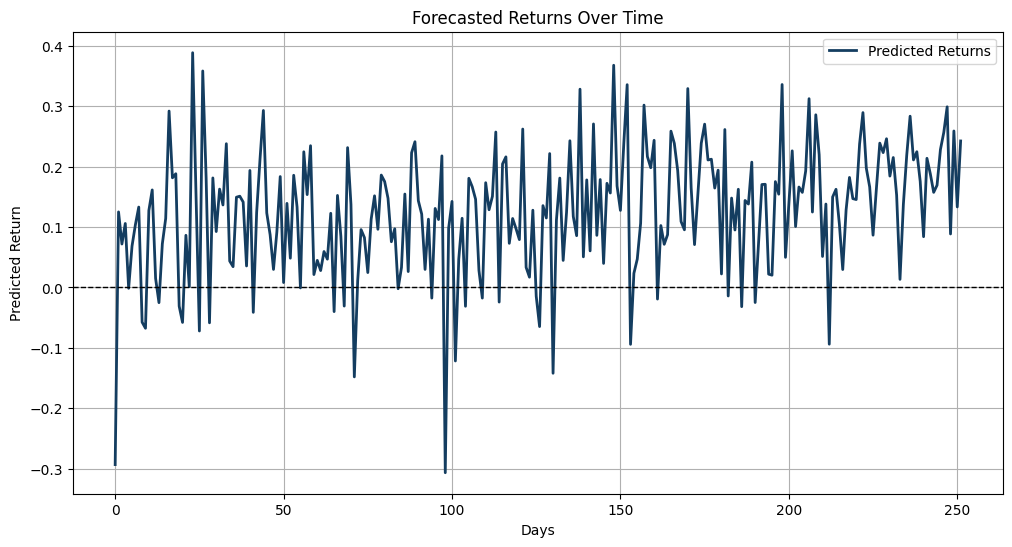

In [72]:
import numpy as np
import matplotlib.pyplot as plt

def plot_forecast(predicted_returns):
    """Plots the predicted returns over the forecast horizon."""
    plt.figure(figsize=(12, 6))
    plt.plot(predicted_returns, label="Predicted Returns", color="#143D60", linewidth=2)
    plt.axhline(y=0, color="black", linestyle="--", linewidth=1)  # Đường tham chiếu mức 0%
    
    plt.xlabel("Days")
    plt.ylabel("Predicted Return")
    plt.title("Forecasted Returns Over Time")
    plt.grid(True)
    plt.legend()
    plt.show()

# Gọi hàm để vẽ
plot_forecast(predicted_returns)
